# WIP: sandbox for experiments

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

# This variable should be set to false, unless you are running this notebook without the
# generated datasets
first_time = False

Remember, we have computed the song word count at three levels of "swear word categories":

In [4]:
offensiveness_rating = pd.read_pickle("../pickles/offensiveness_rating_structured")
offensiveness_rating.head()

('TRAAAAV128F421A322', 'non-discriminatory', 'mild', nan)      1
('TRAAAAV128F421A322', nan, nan, nan)                        102
('TRAAABD128F429CF47', nan, nan, nan)                        226
('TRAAAED128E0783FAB', nan, nan, nan)                        421
('TRAAAEF128F4273421', nan, nan, nan)                        139
Name: count, dtype: int64

Now, the problem is that we have tuples as index but we would like to have all these categories in different columns. So we do some processing to take care of that:

In [5]:
def process_tuple(t):
    
    def process_tuple_elem(elem):
        if elem == "nan":
            return np.nan
        else:
            return elem[1:-1]
    return list(map(process_tuple_elem, t[1:-1].replace(" ", "").split(",")))
index_offensiveness = list(map(process_tuple, offensiveness_rating.index.tolist()))

In [6]:
value_offensiveness = list(offensiveness_rating.values)

In [7]:
data_non_flat = list(zip(index_offensiveness, value_offensiveness))

In [8]:
columns = ["track_id", "category", "strength", "target", "value"]
track_off = pd.DataFrame.from_records([elem[0] + [elem[1]] for elem in data_non_flat], columns=columns)
track_off = track_off.set_index(["track_id", "category", "strength", "target"])
track_off.head()

value
track_id           category           strength target       
TRAAAAV128F421A322 non-discriminatory mild     NaN         1
                   NaN                NaN      NaN       102
TRAAABD128F429CF47 NaN                NaN      NaN       226
TRAAAED128E0783FAB NaN                NaN      NaN       421
TRAAAEF128F4273421 NaN                NaN      NaN       139

That's it, we have our multi-index structure. Now, we have the choice: absolute or relative count of swear words in a song ? This choice is rather difficult. But, in some way, even if a song is longer than another one, we can (for now) consider that simply having more swear words is equivalent to being more vulgar. So let's simply count the number of swear words per song:

In [9]:
%%time 
if first_time:
    track_offensiveness = track_off.groupby(by="track_id").apply(lambda frame: frame.reset_index().dropna(thresh = 3).value.sum())
    track_offensiveness = track_offensiveness.fillna(0)
    track_offensiveness.to_csv("../datasets/track_offensiveness.csv")
else:
    track_offensiveness = pd.read_csv("../datasets/track_offensiveness.csv", header=None)

CPU times: user 96 ms, sys: 8 ms, total: 104 ms
Wall time: 103 ms


And here is our frame relating a song with its offensiveness (so, for example, the song with track ID 'TRAAAAV128F421A322' contains one swear word)

In [10]:
track_offensiveness.columns=["track_id", "offensiveness"]
track_offensiveness.head()

,track_id,offensiveness
0,TRAAAAV128F421A322,1
1,TRAAABD128F429CF47,0
2,TRAAAED128E0783FAB,0
3,TRAAAEF128F4273421,0
4,TRAAAEW128F42930C0,0


We take only the columns we are interested in:

In [11]:
song_info = pd.read_csv("../datasets/total.csv")[["track_id", "genre", "song_hotness",
                                                            "song_id", "title", "year"]]
song_info.head()

,track_id,genre,song_hotness,song_id,title,year
0,TRBEEBA128F9354588,NaN,NaN,SOKZDUY12AC9E12A16,(Sweat_ Sweat),2007
1,TRBEEYF128EF34152F,NaN,NaN,SOEEDAK12A67AE2142,Heavenly (Instrumental Dub),0
2,TRBEEME128F42274E2,NaN,NaN,SOLVIJZ12A6D4FC406,In The Right Way,2000
3,TRBEENM12903CDA90A,NaN,0.51876,SOKLANA12A8C14016F,Hacha Y Machete,1976
4,TRBEETN128F4290E24,NaN,NaN,SOLODJD12A8C139CE3,Bus Stop,1968


### English songs
We now want to do our analysis for english songs only so we read the corresponding track IDs. The process of "detecting" which songs are in english is described in [this notebook](handling_languages.ipynb).

In [12]:
english_songs = pd.read_csv("../datasets/tracks_english.csv", header=-1)[1]
print("We have {} english songs.".format(english_songs.shape[0]))
english_songs = english_songs.to_frame()
english_songs.columns = ["track_id"]
english_songs.head()

We have 202115 english songs.


,track_id
0,TRAAAAV128F421A322
1,TRAAABD128F429CF47
2,TRAAAED128E0783FAB
3,TRAAAEF128F4273421
4,TRAAAEW128F42930C0


In [13]:
english_songs.columns

Index(['track_id'], dtype='object')

In [14]:
track_offensiveness.columns

Index(['track_id', 'offensiveness'], dtype='object')

In [15]:
english_track_offensiveness = english_songs.merge(track_offensiveness, on="track_id")
print("We have {} songs.".format(english_track_offensiveness.shape[0]))
english_track_offensiveness.columns = ["track_id", "abs_offensiveness"]
english_track_offensiveness.head()

We have 202115 songs.


,track_id,abs_offensiveness
0,TRAAAAV128F421A322,1
1,TRAAABD128F429CF47,0
2,TRAAAED128E0783FAB,0
3,TRAAAEF128F4273421,0
4,TRAAAEW128F42930C0,0


In [16]:
song_info_offensiveness = song_info.merge(english_track_offensiveness.reset_index(), on="track_id")
song_info_offensiveness = song_info_offensiveness.rename(columns={0: "abs_offensiveness"})
song_info_offensiveness.head()

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
0,TRBEEGF128F42AB67E,NaN,0.000000,SOMYKOX12A8C13D59F,Collision Course,0,9341,0
1,TRBEEPA128F4291036,NaN,NaN,SOTOLDX12A58A79206,Fermented Offal Discharge,1995,9345,1
2,TRBEEEA128F92E7EED,NaN,NaN,SOGLPMS12D02193D69,Fake Messiah (Album Version),2009,9339,0
3,TRBEERY128F4231A2E,NaN,0.528782,SOVSBWN12A813557F9,Eyes Of A Stranger (Album Version),0,9346,0
4,TRBEEXV128F93116C9,NaN,0.227736,SOJHHMQ12AB017C6A6,Don't Ya Ever Leave Me (Live),0,9348,0


That's good, we have more than 200000 english songs with absolute offensiveness value. The two other values we will be the most focused on are the song hotness and the year. So we need to keep those where the year is not 0 and the song hotness is not nan. For now, let's proceed by keeping only datapoints with positive hotness value.

### Scatter years and offensiveness

In [17]:
songs = song_info_offensiveness[song_info_offensiveness["year"]>0]

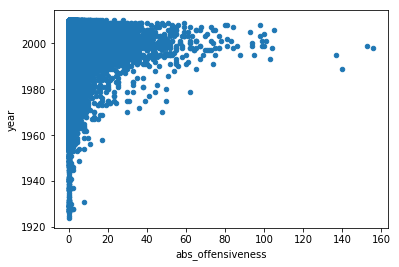

In [18]:
songs.plot.scatter("abs_offensiveness", "year")

### Combine with play counts

In [19]:
songs_counts=pd.read_csv("../datasets/songs-counts.csv")

In [20]:
songs_counts.head()

,songs,counts
0,SOAAADD12AB018A9DD,24
1,SOAAADE12A6D4F80CC,12
2,SOAAADF12A8C13DF62,9
3,SOAAADZ12A8C1334FB,12
4,SOAAAFI12A6D4F9C66,188


## TODO: read the track ids from the datasets, this would need to be uploaded to the drive

### Look at outliers

In [21]:
songs[songs["abs_offensiveness"]>150]

,track_id,genre,song_hotness,song_id,title,year,index,abs_offensiveness
27043,TRIZNAZ12903CA251C,NaN,NaN,SOMAYSH12AB0184269,Bitch Niggas,1999,69975,153
80038,TRSLSAA128F930C4E6,NaN,0.711211,SOHLOTX12A6701FF2D,Gangster Tripping,1998,144126,156
